# Automatic Change-Point Detection

To detect changes in the historical series of air pollution and analize their correlation with significant events or actions taken by authorities with respect to the air quality.

## Change-Point Detection and segmentation with ClaSP

ClaSP (Clasification Score Profile) is an unsupervised method for detecting change points in time series data. ClaSP hierarchically splits a TS into two parts, where each split point is determined by training a binary TS classifier for each possible split point and selecting the one with highest accuracy, i.e., the one that is best at identifying subsequences to be from either of the partitions.

In [201]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd

pd.options.plotting.backend = "plotly"

from src.get_data import get_air_quality_df, get_weather_df, get_madrid_data
from src.models.train_model import train_clasp_model
from src.visualization import visualize_clasp_results
from src.models.prophet_utils import get_trend_deviation_from_changepoint

plt.style.use("seaborn-white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# aq_df = get_air_quality_df("../01-data")
# weather_df = get_weather_df("../01-data").dropna()
# madrid_df = match_data(aq_df, weather_df)
# # madrid_df.columns = madrid_df.columns.str.replace("µ","u")
# # madrid_df = pd.read_feather("../01-data/processed/aq-weather_normalized.feather")
# madrid_df = get_madrid_data("../01-data",normalized=True)

In [2]:
madrid_df = pd.read_feather("../01-data/processed/aq-weather_normalized.feather")

INFO:train_model:Training ClaSP model on timeseries of no2_ug_m3 data on zone 2 with 5 changepoints
INFO:train_model:Model was fit in 1.00 seconds.
INFO:train_model:5 CHANGEPOINT(S) DETECTED


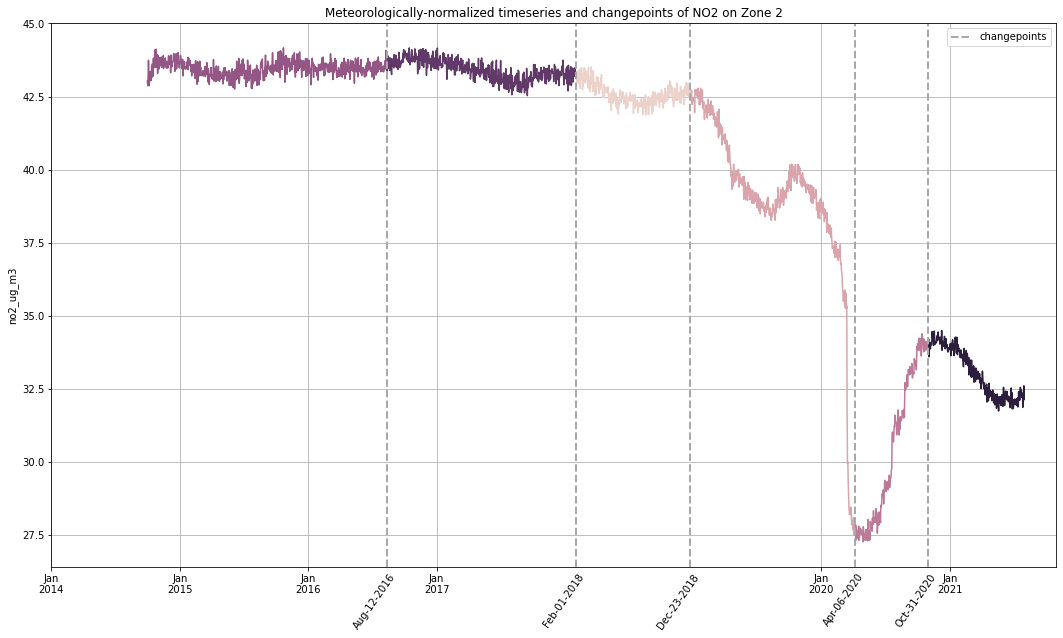

In [10]:
start = "2014-10-01"
end = "2022-02-01"
zone = 2
indicator = 'no2_ug_m3'#'pm10_ug_m3'#'o3_ug_m3' #"no2_ug_m3"
period_length = None # 10

clasp_results = train_clasp_model(
    madrid_df,
    y=indicator,
    location=zone,
    n_changepoints=5,
    train_start=start,
    train_end=end,
    period_length=period_length
)
fig,ax = visualize_clasp_results(
    clasp_results,
    title=f"Meteorologically-normalized timeseries and changepoints of {indicator.split('_')[0].upper()} on Zone {zone}",
    arrowprops=None,
    xytext=(-12,-5),
    rotation=55
)
fig.show()

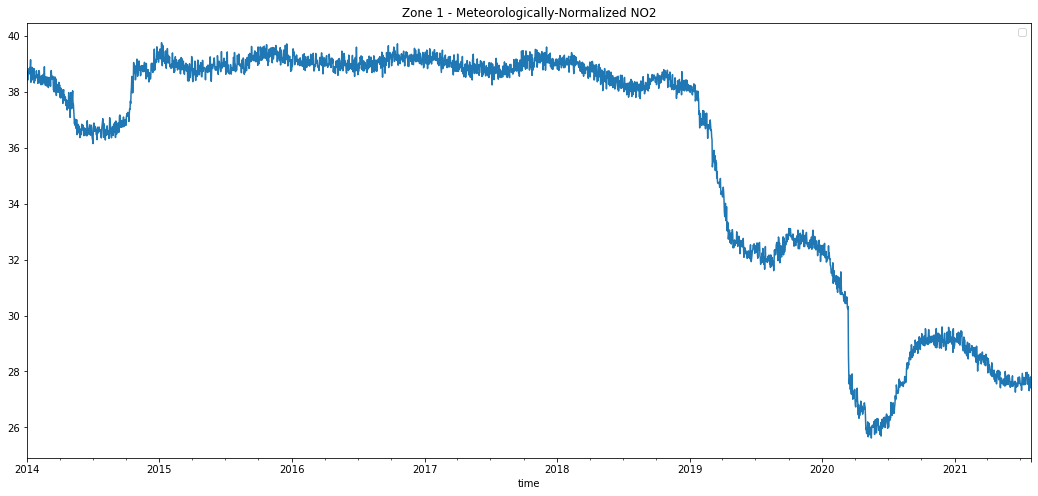

In [17]:
pd.options.plotting.backend = "matplotlib"
zone = 1
fig, ax = plt.subplots(figsize=(18,8))
aq_df = get_air_quality_df("../01-data",meteo_normalized=True)
df = aq_df.copy().set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()

df[df.zone==zone].plot(
    x = "time",
    y = "no2_ug_m3",
    ax=ax
)
ax.set(title="Zone {} - Meteorologically-Normalized NO2".format(zone))
ax.legend([])

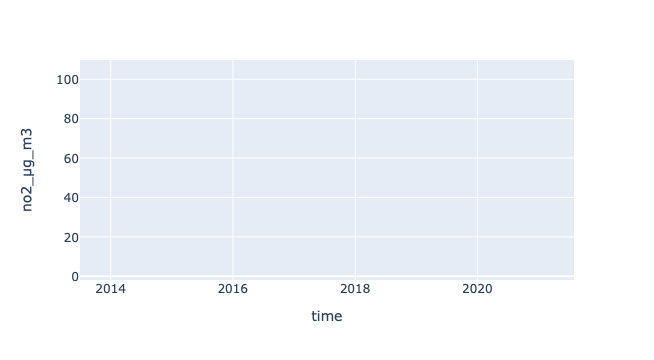

In [51]:
pd.options.plotting.backend = "plotly"

aq_df = get_air_quality_df("../01-data",meteo_normalized=False)
df = aq_df.copy().set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()
df[df.zone==zone].plot(
    x = "time",
    y = "no2_µg_m3",
)

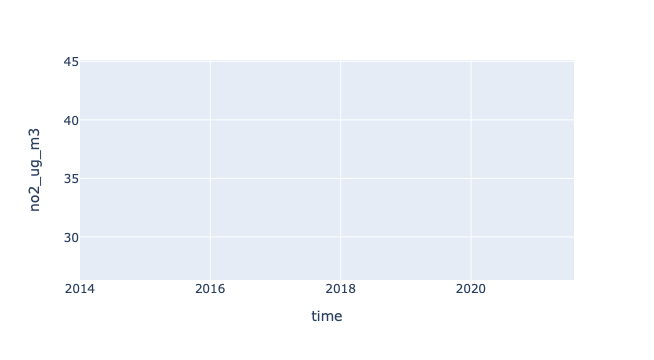

In [52]:
pd.options.plotting.backend = "plotly"

aq_df = get_air_quality_df("../01-data",meteo_normalized=True)
df = aq_df.copy().set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()
df[df.zone==2].plot(
    x = "time",
    y = "no2_ug_m3",
)

In [ ]:
aq_df = get_air_quality_df("../01-data",meteo_normalized=True)
weather_df = get_weather_df("../01-data")
df = aq_df.copy().set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()

zone = 1
pollutant = "no2_ug_m3"

deviation_percent_pre,deviation_percent_post = get_trend_deviation_from_changepoint(
    df,
    pollutant=pollutant,
    location=zone,
    start="2010-01-01",
    end="2021-11-01",
    changepoint="2020-03-10",    
    eval_delta=pd.Timedelta(days=60),
    regressors=weather_df.columns.drop(["time"]),
    eval_start = "2019-12-01",
    pre_cp = pd.Timedelta(days=180),
)
print(f"Predicted trend of {pollutant.split('_')[0].upper()} is on average {deviation_percent_pre:+.2%} away from the real trend "\
    f"before the changepoint and {deviation_percent_post:+.2%} after the changepoint")


------------

### Change-point detection on the traffic time series

In [5]:
from src.get_data import get_traffic_df

traffic_df = get_traffic_df("../01-data")
traffic_df

,time,nombre,cod_cent,id,intensidad,carga,ocupacion
0,2016-04-01 04:00:00,C/. Fuente Carrantona - Paular-José Bergamín,65016,6432.0,32.50,0.50,0.00
1,2016-04-01 05:00:00,C/. Fuente Carrantona - Paular-José Bergamín,65016,6432.0,53.25,0.75,0.00
2,2016-04-01 06:00:00,C/. Fuente Carrantona - Paular-José Bergamín,65016,6432.0,479.50,13.00,4.50
3,2016-04-01 07:00:00,C/. Fuente Carrantona - Paular-José Bergamín,65016,6432.0,2057.25,64.00,29.00
4,2016-04-01 09:00:00,C/. Fuente Carrantona - Paular-José Bergamín,65016,6432.0,1825.75,61.75,21.00
...,...,...,...,...,...,...,...
157959798,2021-09-22 09:00:00,10042,10042,NaN,464.00,18.25,3.75
157959799,2021-09-22 10:00:00,10042,10042,NaN,383.50,15.25,4.00
157959800,2021-09-26 11:00:00,10042,10042,NaN,200.25,7.75,1.50
157959801,2021-09-26 12:00:00,10042,10042,NaN,225.00,9.50,2.25


In [6]:
traffic_df.dtypes

time          datetime64[ns]
nombre                object
cod_cent              object
id                   float64
intensidad           float64
carga                float64
ocupacion            float64
dtype: object

INFO:train_model:Training ClaSP model on timeseries of intensidad data on cod_cent 65016 with 5 changepoints
INFO:train_model:Model was fit in 0.66 seconds.
INFO:train_model:3 CHANGEPOINT(S) DETECTED


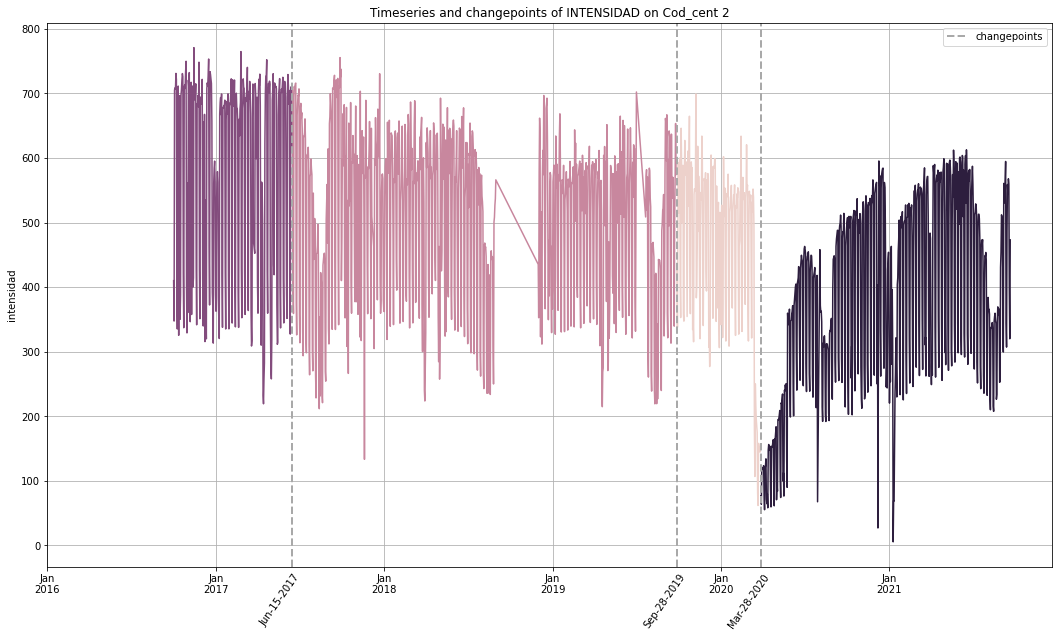

In [9]:
start = "2016-10-01"
end = "2021-12-01"
zone = 2
y = 'intensidad'
location_by = "cod_cent"
location="65016"
period_length = None # 10
num_changepoints = 5

clasp_results = train_clasp_model(
    traffic_df,
    y=y,
    location=location,
    location_by=location_by,
    n_changepoints=num_changepoints,
    train_start=start,
    train_end=end,
    period_length=period_length
)
fig,ax = visualize_clasp_results(
    clasp_results,
    title=f"Timeseries and changepoints of {y.split('_')[0].upper()} on {location_by.capitalize()} {zone}",
    arrowprops=None,
    xytext=(-12,-5),
    rotation=55
)
fig.show()